In [ ]:
%%capture
!pip install wldhx.yadisk-direct -qqq

In [ ]:
!curl -L $(yadisk-direct https://yadi.sk/d/UJ8DEma9LHRMsg) -o track_1.tar
!tar xvf track_1.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C
tar: track_1.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [1]:
#@title Import necessary modules
import pathlib as path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, mean_absolute_error 
import PIL
import random
#from keras.preprocessing.image import array_to_img  # ???

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = '../tests/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
PRIVATE_TEST_PATH = os.path.join(DATA_PATH, 'private_test')
PUBLIC_TEST_PATH = os.path.join(DATA_PATH, 'public_test')

In [3]:
ER = os.path.join(TRAIN_PATH, 'ER')
NR = os.path.join(TRAIN_PATH, 'NR')

In [4]:
len(os.listdir(ER)), len(os.listdir(NR))

(6758, 6646)

In [5]:
names = []

for filename in os.listdir(ER):
    names.append(ER + '/' + filename)
for filename in os.listdir(NR):
    names.append(NR + '/' + filename)

len(names)

13404

In [6]:
for i in range(10):
    split_name = names[i+7000].split('/')[-1]
print(split_name.split('_'))

['-0.2328999936580658', '', 'CYGNO', '60', '40', 'He', 'NR', '20', 'keV', '930V', '30cm', 'SRIM', 'IDAO', 'iso', 'crop', 'hist', 'pic', 'run3', 'ev346;1.png']


In [7]:
def energy_parsing(filenames):
    labels = []
    energies = []
    for i in range(len(filenames)):
        split_name = filenames[i].split('/')[-1]          
        try:
            energies.append(int(split_name.split('_')[6]))
        except:
            energies.append(int(split_name.split('_')[7]))
    for i in range(len(filenames)):
        split_name = filenames[i].split('/')[-1] 
        if split_name.split('_')[5] == 'ER':
            labels.append(split_name.split('_')[5])
        else:
            labels.append(split_name.split('_')[6])
    print('Parsing complete!')
    return labels, energies


labels, energies = energy_parsing(names)

Parsing complete!


In [8]:
len(names), len(labels), len(energies)

(13404, 13404, 13404)

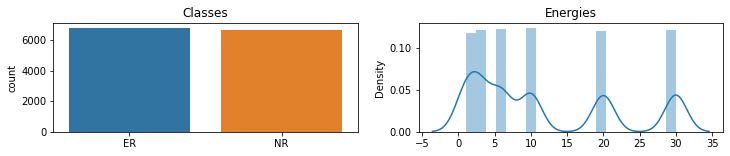

In [9]:
#@title Deviation of labels and energies

plt.figure(figsize=(12,2))
plt.subplot(1, 2, 1)
plt.title('Classes')
sns.countplot(labels)
plt.subplot(1, 2, 2)
plt.title('Energies')
sns.distplot(np.array(energies))
plt.show()

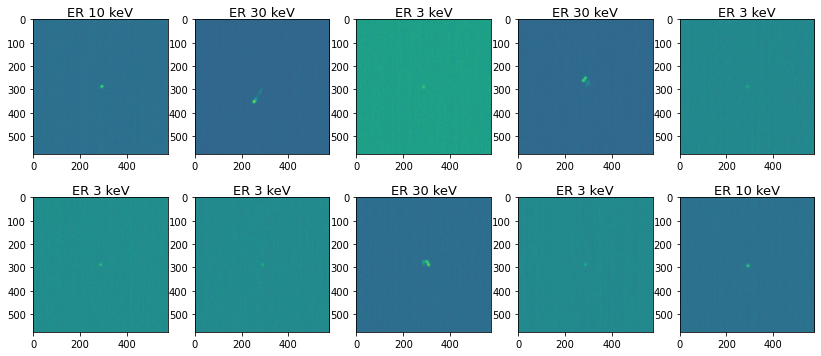

In [10]:
#@title ER images

er, nr = len(os.listdir(ER)), len(os.listdir(NR))
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    idx = random.randint(0, er-1)
    plt.imshow(plt.imread(names[idx]))
    plt.title(str(labels[idx]) + ' ' + str(energies[idx]) + ' keV', size=13, pad=1)
plt.show()

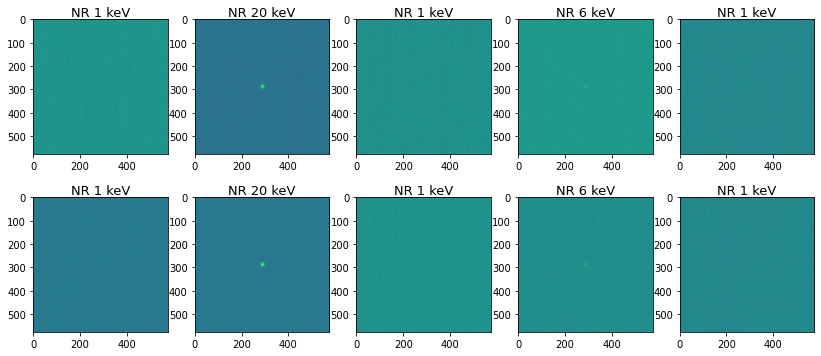

In [11]:
#@title NR images

plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    idx = random.randint(er, er+nr-1)
    #print(names[idx])
    plt.imshow(plt.imread(names[idx]))
    plt.title(str(labels[idx]) + ' ' + str(energies[idx]) + ' keV', size=13, pad=1)
plt.show()

In [12]:
#@title Classification problem


In [13]:
label_encoder = {'ER': 0, 'NR': 1}
encoded_labels = list(pd.Series(labels).replace(label_encoder))

In [16]:
from collections import Counter
Counter(encoded_labels)

Counter({0: 6758, 1: 6646})

In [ ]:
images = []
for i in range(len(names)):
    images.append(np.expand_dims(np.asarray(PIL.Image.open(names[i])), -1))

In [ ]:
images[0].shape

(576, 576, 1)

In [ ]:
# for regression, it is required to use 'Energies' var for train_test_split! 
x_train, x_REST, y_train, y_REST = train_test_split(
    images, encoded_labels, test_size=0.2, shuffle=True, random_state = 17)

x_val, x_test, y_val, y_test = train_test_split(
    x_REST, y_REST, test_size=0.5, shuffle=False, random_state = 17)

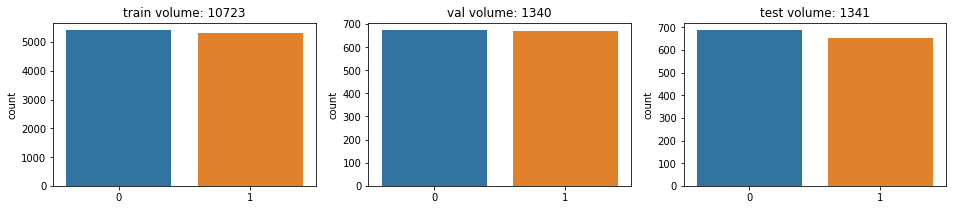

In [ ]:
#@title Train, val, test datasets

plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
sns.countplot(y_train)
plt.title('train volume: ' + str(len(y_train)))
plt.subplot(1,3,2)
sns.countplot(y_val)
plt.title('val volume: ' + str(len(y_val)))
plt.subplot(1,3,3)
sns.countplot(y_test)
plt.title('test volume: ' + str(len(y_test)))

plt.show()

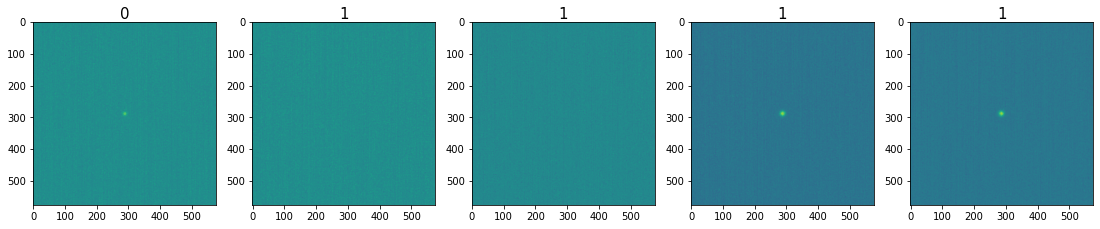

In [ ]:
#@title Images from train x_train

plt.figure(figsize=(19, 5))
for i in range(5):
    j = random.randint(0, len(x_train)-1)
    plt.subplot(1, 5, i+1)
    plt.imshow(np.squeeze(x_train[j]))
    plt.title(y_train[j], size=15, pad=1)


In [ ]:
BATCH_SIZE = 50                                         # BATCH SIZE
IMSIZE = (576, 576, 1)                                  # IMSIZE
LEARNING_RATE = 1e-4                                    # LEARNING_RATE
EPOCHS = 20                                             # EPOCHS

In [ ]:
x_train[0].shape

(576, 576, 1)

In [ ]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=IMSIZE),
    tf.keras.layers.Lambda(lambda x: x / 255.0),
    tf.keras.layers.MaxPooling2D((3, 3)),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 574, 574, 32)      320       
_________________________________________________________________
lambda_5 (Lambda)            (None, 574, 574, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 191, 191, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 189, 189, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 20, 20, 128)      

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss = 'binary_crossentropy',
    metrics = [keras.metrics.AUC(), 'accuracy']
)
history = model.fit(
    np.array(x_train), 
    np.array(y_train), 
    validation_data = (np.array(x_val), np.array(y_val)),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    verbose=2
)

Epoch 1/20
215/215 - 37s - loss: 0.6934 - auc_7: 0.4967 - accuracy: 0.5014 - val_loss: 0.6930 - val_auc_7: 0.5000 - val_accuracy: 0.5030
Epoch 2/20
215/215 - 37s - loss: 0.6930 - auc_7: 0.5140 - accuracy: 0.5089 - val_loss: 0.6931 - val_auc_7: 0.5000 - val_accuracy: 0.5015
Epoch 3/20
215/215 - 37s - loss: 0.6927 - auc_7: 0.5163 - accuracy: 0.5166 - val_loss: 0.6917 - val_auc_7: 0.6763 - val_accuracy: 0.6172
Epoch 4/20
215/215 - 36s - loss: 0.6897 - auc_7: 0.5637 - accuracy: 0.5376 - val_loss: 0.6893 - val_auc_7: 0.7373 - val_accuracy: 0.5015
Epoch 5/20
215/215 - 37s - loss: 0.6757 - auc_7: 0.6334 - accuracy: 0.5954 - val_loss: 0.6493 - val_auc_7: 0.8113 - val_accuracy: 0.6701
Epoch 6/20
215/215 - 36s - loss: 0.6306 - auc_7: 0.7066 - accuracy: 0.6475 - val_loss: 0.6120 - val_auc_7: 0.8435 - val_accuracy: 0.7448
Epoch 7/20
215/215 - 37s - loss: 0.5661 - auc_7: 0.7707 - accuracy: 0.6968 - val_loss: 0.5395 - val_auc_7: 0.8671 - val_accuracy: 0.6739
Epoch 8/20
215/215 - 37s - loss: 0.5207 -

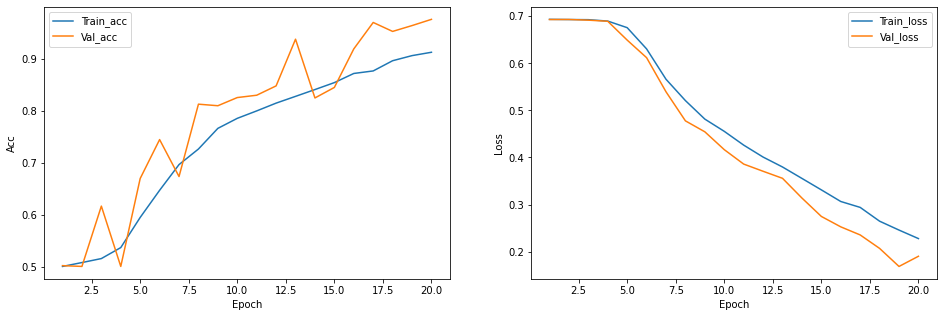

In [ ]:
#@title Training and validation curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Train_acc', 'Val_acc'])

plt.subplot(1,2,2)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train_loss', 'Val_loss'])
plt.show()

In [ ]:
#@title Predeiction
y_pred = model.predict_classes(np.array(x_test))
y_pred = (y_pred.reshape(-1))

In [ ]:
print('f1_score: {} \nroc_auc_score: {}'.format(
    f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred))
)

f1_score: 0.9704769114307343 
roc_auc_score: 0.9710914027552133


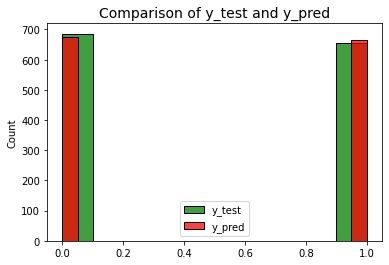

In [ ]:
sns.histplot(np.array(y_test), color='green', binwidth=0.1)
sns.histplot(np.array(y_pred), color='red', binwidth=0.05)
plt.legend(['y_test', 'y_pred'])
plt.title('Comparison of y_test and y_pred', size=14)
plt.show()

In [ ]:
#@title Regression problem

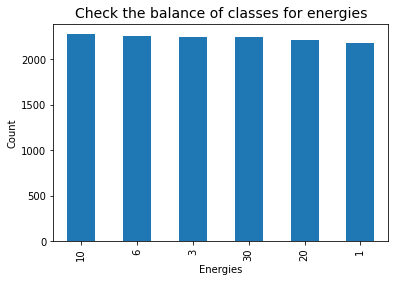

In [ ]:
#@title 
pd.Series(energies).value_counts().plot(kind='bar')
plt.title('Check the balance of classes for energies', size=14)
plt.xlabel('Energies')
plt.ylabel('Count')
plt.show()

In [ ]:
energies[:20]

[30, 10, 30, 10, 30, 30, 30, 3, 30, 30, 30, 10, 10, 10, 10, 10, 3, 10, 30, 10]

In [ ]:
x_train, x_REST, y_train, y_REST = train_test_split(
    images, energies, test_size=0.2, shuffle=True, random_state = 17)

x_val, x_test, y_val, y_test = train_test_split(
    x_REST, y_REST, test_size=0.5, shuffle=False, random_state = 17)

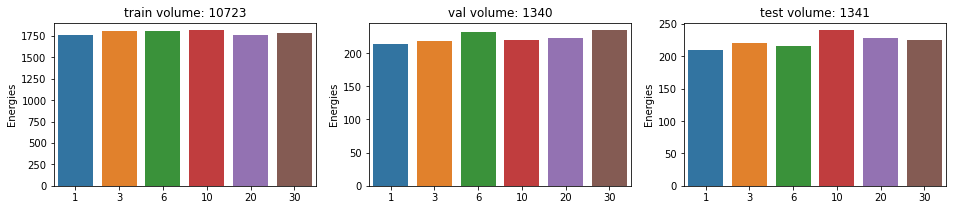

In [ ]:
#@title Train, val, test datasets

plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
sns.countplot(y_train)
plt.title('train volume: ' + str(len(y_train)))
plt.ylabel('Energies')
plt.subplot(1,3,2)
sns.countplot(y_val)
plt.title('val volume: ' + str(len(y_val)))
plt.ylabel('Energies')
plt.subplot(1,3,3)
sns.countplot(y_test)
plt.title('test volume: ' + str(len(y_test)))
plt.ylabel('Energies')
plt.show()

In [ ]:
BATCH_SIZE = 20
IMSIZE = (576, 576, 1)
LEARNING_RATE = 1e-4
EPOCHS = 100

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=IMSIZE),
    tf.keras.layers.Lambda(lambda x: x / 255.0),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 574, 574, 64)      640       
_________________________________________________________________
lambda_7 (Lambda)            (None, 574, 574, 64)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 191, 191, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 189, 189, 64)      36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 20, 20, 128)      

In [ ]:
#np.array(x_train).shape, np.array(y_train).shape

In [ ]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = LEARNING_RATE, momentum = 0.9),
    loss = 'mean_absolute_error',
    metrics = ['accuracy'])  # metrics = ['accuracy']

history_2 = model.fit(
    np.array(x_train), 
    np.array(y_train),
    validation_data = (np.array(x_val), np.array(y_val)),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    verbose=2)

Epoch 1/100
537/537 - 64s - loss: 6.7216 - accuracy: 0.1542 - val_loss: 3.2654 - val_accuracy: 0.1597
Epoch 2/100
537/537 - 62s - loss: 2.5791 - accuracy: 0.1441 - val_loss: 2.1660 - val_accuracy: 0.1597
Epoch 3/100
537/537 - 62s - loss: 2.1285 - accuracy: 0.1513 - val_loss: 1.9366 - val_accuracy: 0.1433
Epoch 4/100
537/537 - 62s - loss: 1.7756 - accuracy: 0.1552 - val_loss: 1.3986 - val_accuracy: 0.1545
Epoch 5/100
537/537 - 62s - loss: 1.3793 - accuracy: 0.1547 - val_loss: 1.3921 - val_accuracy: 0.1597
Epoch 6/100
537/537 - 62s - loss: 1.1667 - accuracy: 0.1502 - val_loss: 1.0863 - val_accuracy: 0.1597
Epoch 7/100
537/537 - 62s - loss: 1.0743 - accuracy: 0.1558 - val_loss: 1.2750 - val_accuracy: 0.1597
Epoch 8/100
537/537 - 62s - loss: 1.0585 - accuracy: 0.1552 - val_loss: 0.8925 - val_accuracy: 0.1597
Epoch 9/100
537/537 - 62s - loss: 0.9264 - accuracy: 0.1573 - val_loss: 0.7497 - val_accuracy: 0.1597
Epoch 10/100
537/537 - 62s - loss: 0.9107 - accuracy: 0.1558 - val_loss: 0.9824 - 

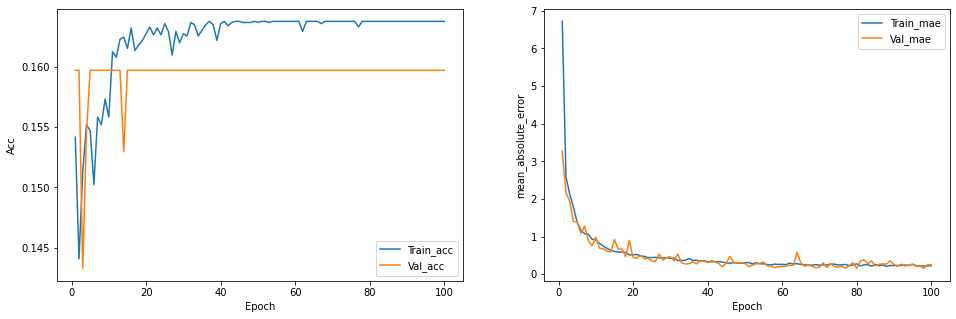

In [ ]:
#@title Training and validation curves
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Train_acc', 'Val_acc'])

plt.subplot(1,2,2)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend(['Train_mae', 'Val_mae'])
plt.show()

In [ ]:
y_pred_reg = model.predict(np.array(x_test))
y_pred_reg = y_pred_reg.reshape(-1)
y_pred_reg.shape

(1341,)

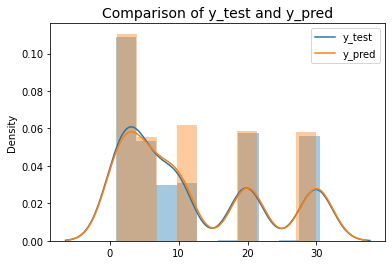

In [ ]:
sns.histplot(np.array(y_test))  #, binwidth=0.1)
sns.histplot(np.array(y_pred_reg))  #, binwidth=0.05)
plt.legend(['y_test', 'y_pred'])
plt.title('Comparison of y_test and y_pred_reg', size=14)
plt.show()

In [ ]:
print('MAE: ', mean_absolute_error(y_test, y_pred_reg))

MAE:  0.2547078567774415
